In [1]:
%pip install arcticdb
import arcticdb as adb
adb.__version__

Looking in indexes: https://repo.prod.m/artifactory/api/pypi/pegasus-311-1/simple/
Note: you may need to restart the kernel to use updated packages.


'5.9.0+man2'

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [5]:
def ols_coef (df, xcol, ycol):
    """simple OLS function used for lambda calcs -- assumes univariate regression"""
    model=sm.OLS(df[ycol],sm.add_constant(df[xcol])).fit()    

    outdf = pd.DataFrame({'adj.'    : model.params.iloc[0],
                          'adj. se' : model.bse.iloc[0],
                          'λ'    : model.params.iloc[1],
                          'λ se' : model.bse.iloc[1],
                          'nobs' : model.nobs,
                          'adj. $R^2$': model.rsquared_adj}, index=[0])    

    return outdf

Our study period is from 2010 to 2019

In [6]:
st_year_ = 2010
end_year_ = 2019

### Connect to ArcticDB and get list of leagues

In [7]:
arctic = adb.Arctic('lmdb://sports')
league_data = arctic.get_library('leagues')
leagues = league_data.list_symbols()
leagues

['IPL', 'LAX', 'EPL', 'SUP', 'MLB', 'AFL', 'NFL', 'NHL', 'NBA']

In [ ]:
# points scored for all games
lazy_dfs = league_data.read_batch(leagues, lazy=True)
lazy_dfs = lazy_dfs[(lazy_dfs['YEAR_ID']>=st_year_) & (lazy_dfs['YEAR_ID']<=end_year_)]
lazy_dfs = adb.concat(lazy_dfs)
points_scored = lazy_dfs.collect().data[['LEAGUE', 'PS']]
points_scored

,LEAGUE,PS
127470,IPL,159
127471,IPL,164
127472,IPL,203
127473,IPL,136
127474,IPL,135
...,...,...
703617,NBA,95
703618,NBA,114
703619,NBA,112
703620,NBA,110


### Figure 1 calculate points-scored stats
- check positive skew comment in text
- note need help to plot via python like r panel plot

In [15]:
point_stats = points_scored.groupby(['LEAGUE']).agg(Mean=('PS', 'mean'),
                                             Std=('PS', 'std'),
                                             Skew=('PS', 'skew'),
                                             nobs=('PS', 'count'))
point_stats['IR']=point_stats['Mean']/point_stats['Std']
point_stats = point_stats.sort_values(['IR'])
point_stats.round(2)

,Mean,Std,Skew,nobs,IR
LEAGUE,,,,,
EPL,1.38,1.26,1.03,7600,1.09
MLB,4.39,3.10,1.00,48594,1.42
NHL,2.81,1.64,0.42,23744,1.71
SUP,25.10,11.97,0.88,2402,2.10
NFL,22.64,10.18,0.29,5120,2.23
LAX,10.26,3.98,0.50,10006,2.58
AFL,88.30,27.75,0.48,3892,3.18
IPL,163.27,31.42,0.16,1274,5.20
NBA,102.24,12.66,0.18,24118,8.08


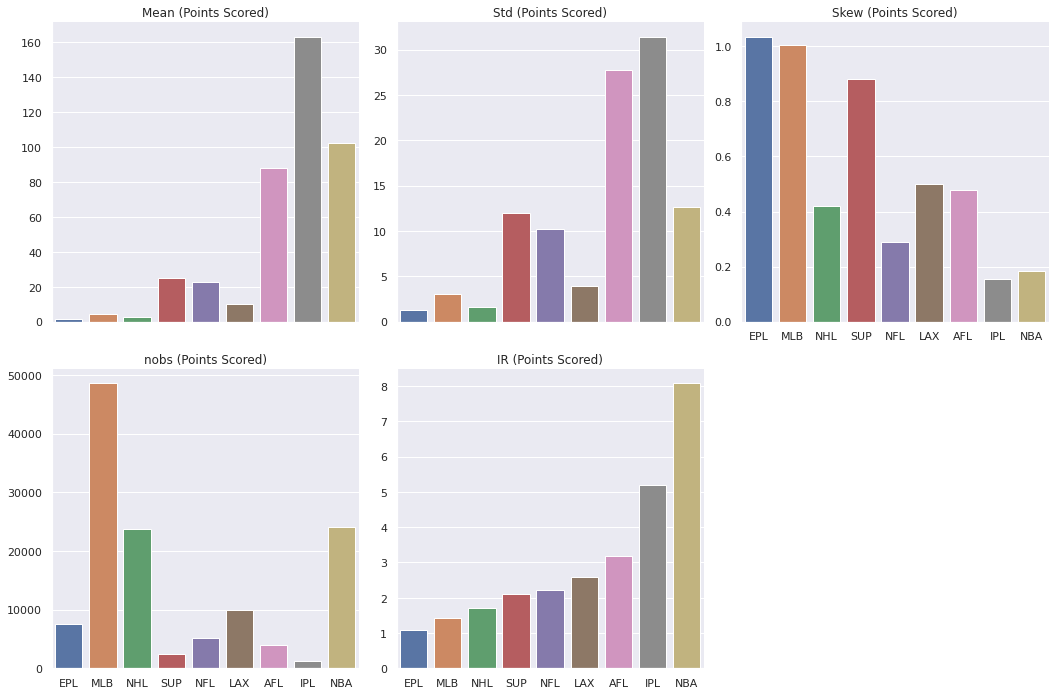

In [16]:
grid = sns.catplot(point_stats.reset_index().melt(['LEAGUE']),
                   kind="bar",
                   x="LEAGUE",
                   y="value",
                   hue="LEAGUE",
                   col="variable",
                   col_wrap=3,
                   sharey=False)
grid.set_axis_labels("", "")
grid.set_titles("{col_name} (Points Scored)");

### Save into ArcticDB

In [17]:
analysis = arctic.get_library('analysis', create_if_missing=True)
analysis.write('point_stats', point_stats)

VersionedItem(symbol='point_stats', library='analysis', data=n/a, version=0, metadata=None, host='LMDB(path=/users/is/mmorozov/man/greg.article/sports)', timestamp=1751459904599425717)

### Regress points against wins
set up data for regresion by aggregating by league-team-season

In [ ]:
lazy_dfs = league_data.read_batch(leagues, lazy=True)
df = adb.concat(lazy_dfs).collect().data[['LEAGUE','YEAR_ID','TEAM_ID','PS','PA','wi']]
df_team = df.groupby(['LEAGUE','YEAR_ID','TEAM_ID']).agg(PS=('PS', 'mean'),
                                                         PA=('PA', 'mean'),
                                                         wi=('wi', 'mean'),
                                                         nobs=('wi', 'count'))
df_team.round(2).head()

PS     PA    wi  nobs
LEAGUE YEAR_ID TEAM_ID                              
AFL    1897    Carlton      26.86  52.64  0.14    14
               Collingwood  36.36  31.79  0.64    14
               Essendon     50.43  31.79  0.79    14
               Fitzroy      36.36  34.64  0.32    14
               Geelong      50.29  27.36  0.79    14

### Figure 2 -- NBA and EPL

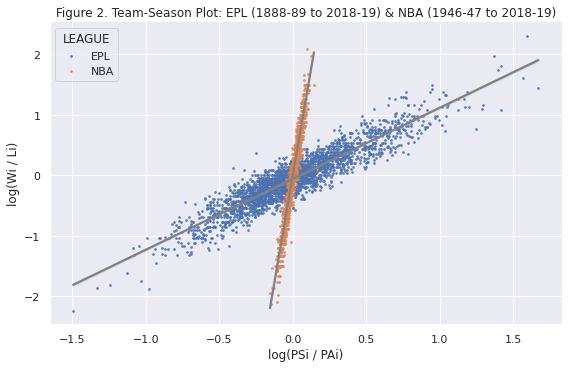

In [19]:
# prepare data for regression
df_reg = df_team.copy()
df_reg = df_reg.loc[(df_reg['PS']>0) & (df_reg['PA']>0) & (df_reg['wi']>0) & (df_reg['wi']<1)]
df_reg['lnwi']=np.log(df_reg['wi']/(1-df_reg['wi']))
df_reg['lnPSPA']=np.log(df_reg['PS']/df_reg['PA'])
df_reg = df_reg.reset_index()

# plot
NBA_and_EPL = df_reg[df_reg['LEAGUE'].isin(['NBA', 'EPL'])]
sns.lmplot(data=NBA_and_EPL,
           x='lnPSPA',
           y='lnwi',
           hue='LEAGUE',
           scatter_kws=dict(s=3),
           line_kws=dict(color="grey"),
           facet_kws=dict(legend_out=False),
           aspect=1.6)
plt.title('Figure 2. Team-Season Plot: EPL (1888-89 to 2018-19) & NBA (1946-47 to 2018-19)')
plt.xlabel('log(PSi / PAi)')
plt.ylabel('log(Wi / Li)');

In [20]:
# Compute standard regression results by team-season for 2010-19 period
df_ols = df_reg.loc[(df_reg['YEAR_ID']>=st_year_) & (df_reg['YEAR_ID']<=end_year_)]
ols=df_ols.groupby(['LEAGUE']).apply(ols_coef,xcol=['lnPSPA'],ycol=['lnwi'])
ols = ols.droplevel(1).sort_values(['λ']).reset_index().round(2)
ols

,LEAGUE,adj.,adj. se,λ,λ se,nobs,adj. $R^2$
0,EPL,-0.15,0.01,1.24,0.02,200.0,0.94
1,MLB,-0.00,0.01,1.78,0.04,300.0,0.89
2,NHL,0.24,0.01,2.06,0.04,302.0,0.91
3,SUP,-0.03,0.03,2.60,0.09,154.0,0.84
4,NFL,0.02,0.02,2.84,0.08,319.0,0.81
5,LAX,-0.02,0.01,3.17,0.05,655.0,0.84
6,AFL,-0.02,0.02,3.57,0.09,177.0,0.90
7,IPL,-0.02,0.04,6.79,0.65,84.0,0.57
8,NBA,-0.00,0.01,14.32,0.21,300.0,0.94


### Save into ArcticDB

In [21]:
analysis.write('ols', ols);

### Figure 3a -- 2010 to 2019

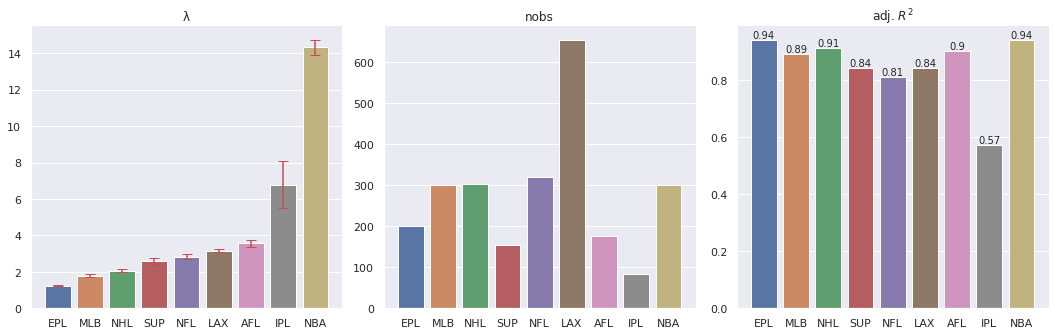

In [22]:
grid = sns.catplot(ols.melt(['LEAGUE']),
                   kind="bar",
                   x="LEAGUE",
                   y="value",
                   hue="LEAGUE",
                   col="variable",
                   col_order=["λ", "nobs", "adj. $R^2$"],
                   sharey=False)
grid.set_axis_labels("", "")
grid.set_titles("{col_name}")
# add error bars to λ
axis = grid.facet_axis(0, 0, True)
axis.errorbar(ols['LEAGUE'], ols['λ'], yerr=ols['λ se']*2, fmt="none", capsize=5, color="r")
# add labels to R^2
axis = grid.facet_axis(0, 2, True)
[axis.bar_label(c, fontsize=10) for c in axis.containers];

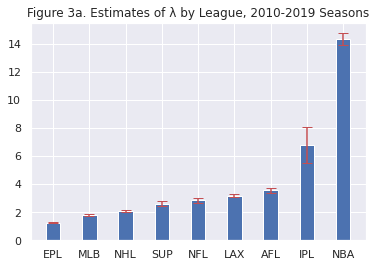

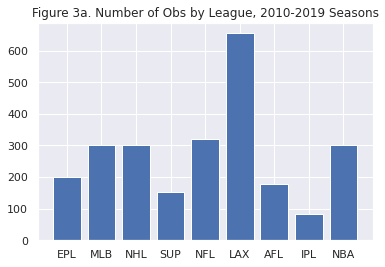

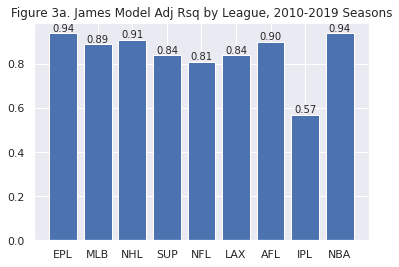

In [23]:
bar_width = 0.4

x = np.arange(len(ols['LEAGUE']))

plt.bar(ols['LEAGUE'],ols['λ'],bar_width,label='OLS')
plt.errorbar(ols['LEAGUE'], ols['λ'], yerr=ols['λ se']*2, fmt="none", capsize=5, color="r")
plt.title('Figure 3a. Estimates of λ by League, 2010-2019 Seasons')
plt.show()

# Number of Obs: Referenced in the text (No chart)
fig, ax = plt.subplots()
bars = ax.bar(ols['LEAGUE'], ols['nobs'])
plt.title('Figure 3a. Number of Obs by League, 2010-2019 Seasons')
plt.show()

# Adj Rsq: Referenced in the text text (No chart)
fig, ax = plt.subplots()
bars = ax.bar(ols['LEAGUE'], ols['adj. $R^2$'])
ax.bar_label(bars,fmt='%.2f')
plt.title('Figure 3a. James Model Adj Rsq by League, 2010-2019 Seasons')
plt.show()

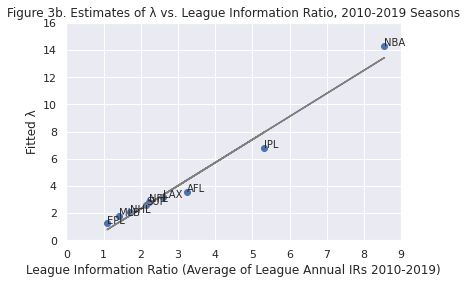

In [24]:
# calculate mean league IRs group by league-season
df_leagueM = df[['LEAGUE','YEAR_ID','PS','PA','wi']].groupby(['LEAGUE','YEAR_ID']).mean()
df_leagueS = df[['LEAGUE','YEAR_ID','PS','PA','wi']].groupby(['LEAGUE','YEAR_ID']).std()
df_leagueIR = df_leagueM['PS']/df_leagueS['PS']
df_leagueIR = df_leagueIR.reset_index().rename(columns={'PS': 'IR'})

# calc 10 year average for 2010-2019
df_leagueIR10 = df_leagueIR.loc[(df_leagueIR['YEAR_ID']>=st_year_) & (df_leagueIR['YEAR_ID']<=end_year_)]
df_leagueIR10 = df_leagueIR10[['LEAGUE','IR']].groupby(['LEAGUE']).mean()
df_leagueIR10 = df_leagueIR10.reset_index().rename(columns={'IR': 'IR10'})
df_leagueIR10 = df_leagueIR10.merge(ols, how='left', on=['LEAGUE'])

plt.scatter(x=df_leagueIR10['IR10'], y=df_leagueIR10['λ'])

# Fit a linear regression model
model=sm.OLS(df_leagueIR10['λ'],sm.add_constant(df_leagueIR10['IR10'])).fit()    

# Plot the regression line
plt.plot(df_leagueIR10['IR10'], model.predict(), color='gray')

# Add labels to the data points
for i in range(len(df_leagueIR10)):
    plt.text(df_leagueIR10['IR10'][i], df_leagueIR10['λ'][i], f"{df_leagueIR10['LEAGUE'][i]}")
    
plt.xlabel('League Information Ratio (Average of League Annual IRs 2010-2019)') 
plt.ylabel('Fitted λ')
plt.xlim(0,9)
plt.ylim(0,16)
plt.title('Figure 3b. Estimates of λ vs. League Information Ratio, 2010-2019 Seasons')
plt.show()